In [68]:
from functools import partial
import operator
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.base import (BaseEstimator, 
                          ClassifierMixin)
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import (ConvergenceWarning, 
                                UndefinedMetricWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             auc, 
                             f1_score,
                             make_scorer,
                             precision_score, 
                             recall_score, 
                             roc_curve)
from sklearn.model_selection import (cross_val_score, 
                                     GridSearchCV,
                                     learning_curve, 
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import (make_pipeline, 
                              Pipeline)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import (LinearSVC, 
                         SVC)
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

In [2]:
cwd = Path.cwd()
pkl_path = cwd / 'data' / 'audio_df.pkl'

In [129]:
audio_df = pd.read_pickle(pkl_path)
audio_df.shape

(2121, 89)

In [130]:
audio_df.head(2)

,song,seg,tempo,dynamic_tempo_mean,dynamic_tempo_median,dynamic_tempo_std,dynamic_tempo_amin,dynamic_tempo_amax,pitch_0_mean,pitch_0_median,...,spectral_flatness_median,spectral_flatness_std,spectral_flatness_amin,spectral_flatness_amax,spectral_rolloff_mean,spectral_rolloff_median,spectral_rolloff_std,spectral_rolloff_amin,spectral_rolloff_amax,artist
0,21StCentury,0,117.453835,116.845143,117.453835,1.654658,112.347147,117.453835,0.427060,0.404514,...,0.030193,0.048358,0.000559,0.875394,6097.246464,6336.145020,1629.179177,2239.453125,9366.943359,RedHotChiliPeppers
1,21StCentury,1,117.453835,116.818981,117.453835,2.229267,112.347147,123.046875,0.451266,0.422953,...,0.050188,0.046202,0.001887,0.340866,6458.052616,6416.894531,953.517885,3090.014648,9334.643555,RedHotChiliPeppers


In [6]:
X = audio_df.drop(columns=['song', 'seg', 'artist'])
y = audio_df['artist'].map({'Eminem': 0, 'RedHotChiliPeppers': 1})

In [106]:
class BaselineClassifier(BaseEstimator, ClassifierMixin):
    """A classifier that always predicts the baseline class."""
    
    def __init__(self, baseline=None):
        self.baseline = baseline
    
    def fit(self, X=None, y=None):
        return
    
    def predict(self, X):
        return np.full(len(X), self.baseline)
    

EminemClassifier = BaselineClassifier(0)
RHCPClassifier = BaselineClassifier(1)

In [108]:
def cv_score(estimator, X, y, cv=5, scoring=None):
    """Return the mean score of an estimator and classifier objects X and y using cross validation."""
    
    scalar = StandardScaler()
    pipeline = Pipeline([('transformer', scalar), ('estimator', estimator)])
    cvs = cross_val_score(estimator=pipeline, 
                          X=X, 
                          y=y, 
                          cv=cv,
                          scoring=scoring)
    return cvs.mean()


def score_estimator(estimator):
    """Return dict with name of scorer as key and the score as the value for each scorer."""
    return {name: cv(estimator) for name, cv in zip(metric_names, cv_metrics)}


cv_X_y = partial(cv_score, X=X, y=y)
cv_accuracy = partial(cv_X_y, scoring=make_scorer(accuracy_score))
cv_f1 = partial(cv_X_y, scoring=make_scorer(f1_score))
cv_precision = partial(cv_X_y, scoring=make_scorer(precision_score))
cv_recall = partial(cv_X_y, scoring=make_scorer(recall_score))

metric_scores = [accuracy_score, f1_score, precision_score, recall_score]
metric_names = [metric.__name__ for metric in metric_scores]
cv_metrics = [cv_accuracy, cv_f1, cv_precision, cv_recall]

In [111]:
def plot_roc_calc_auc(estimator, X_train, X_test, y_train, y_test):
    """Plot the ROC and return the AUC."""
    
    estimator.fit(X_train, y_train)
    y_score = estimator.predict_proba(X_test)
    false_pos, true_pos, _ = roc_curve(y_test, y_score[:,1])
    
    plt.plot(false_pos, true_pos)
    
    est_name = type(estimator).__name__
    default_params = type(estimator)().get_params().items()
    estimator_params = estimator.get_params().items()
    hyper_params = (est_p for def_p, est_p in zip(default_params, estimator_params) if def_p != est_p)
    hyper_params = (f'{arg}={val}' for arg, val in hyper_params)
    hyper_params = ', '.join(hyper_params)
    
    plt.title(f'ROC: {est_name}({hyper_params})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    return f'AUC: {auc(false_pos, true_pos)}'


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plot_roc_calc_auc_audio = partial(plot_roc_calc_auc, 
                                  X_train=X_train,
                                  X_test=X_test,
                                  y_train=y_train,
                                  y_test=y_test)

In [81]:
def grid_search_cv(estimator, param_grid, X, y, cv=5):
    """Return best_params_ after applying a standard scaler"""
    
    scaler = StandardScaler()
    grid = make_pipeline(scaler, GridSearchCV(estimator, param_grid=param_grid, cv=cv))
    grid.fit(X, y)
    return grid.named_steps['gridsearchcv'].best_params_


grid_cv = partial(grid_search_cv, X=X, y=y)

# Baselines

In [45]:
score_estimator(EminemClassifier)

{'accuracy_score': 0.4507302996670366,
 'f1_score': 0.0,
 'precision_score': 0.0,
 'recall_score': 0.0}

In [46]:
score_estimator(RHCPClassifier)

{'accuracy_score': 0.5492697003329634,
 'f1_score': 0.7090690390602953,
 'precision_score': 0.5492697003329634,
 'recall_score': 1.0}

# KNN

In [82]:
param_grid = {'n_neighbors': range(1, 21)}
knn_best = grid_cv(KNeighborsClassifier(), param_grid=param_grid)
knn_best

{'n_neighbors': 16}

In [83]:
score_estimator(KNeighborsClassifier(**knn_best))

{'accuracy_score': 0.822739178690344,
 'f1_score': 0.8486761616217471,
 'precision_score': 0.8045461471087944,
 'recall_score': 0.9012875536480687}

'AUC: 0.9816573348264277'

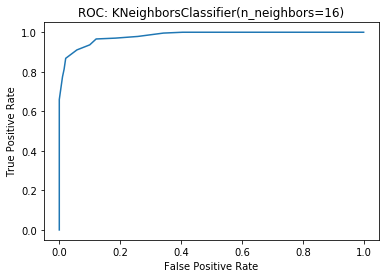

In [113]:
plot_roc_calc_auc_audio(KNeighborsClassifier(**knn_best))

# Logistic Regression

In [85]:
param_grid = {'C': [pow(10, i) for i in range(-3, 4)], 'penalty': ['l1', 'l2']}
logreg_best = grid_cv(LogisticRegression(), param_grid=param_grid)
logreg_best

{'C': 0.1, 'penalty': 'l1'}

In [86]:
score_estimator(LogisticRegression(**logreg_best))

{'accuracy_score': 0.9014739178690345,
 'f1_score': 0.9106312570853327,
 'precision_score': 0.9069227220203826,
 'recall_score': 0.9150214592274677}

'AUC: 0.9779619260918253'

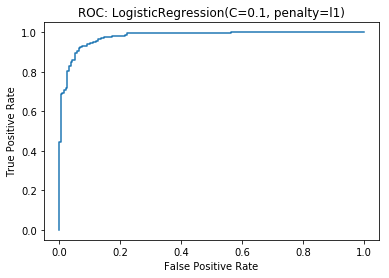

In [114]:
plot_roc_calc_auc_audio(LogisticRegression(**logreg_best))

# Gaussian Naive Bayes

In [88]:
score_estimator(GaussianNB())

{'accuracy_score': 0.8382996670366261,
 'f1_score': 0.849738274346584,
 'precision_score': 0.8714689488979721,
 'recall_score': 0.832618025751073}

'AUC: 0.9234042553191489'

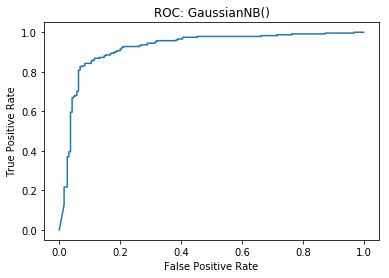

In [115]:
plot_roc_calc_auc_audio(GaussianNB())

# Linear SVC

In [90]:
score_estimator(LinearSVC())  # does not have predict_proba to allow use of AUC

{'accuracy_score': 0.891558268590455,
 'f1_score': 0.9015630850759223,
 'precision_score': 0.8940583670969063,
 'recall_score': 0.9115879828326181}

In [121]:
score_estimator(SVC(kernel='linear'))

{'accuracy_score': 0.8830732519422864,
 'f1_score': 0.8957721981403426,
 'precision_score': 0.8782175748134291,
 'recall_score': 0.9150214592274679}

'AUC: 0.975879059350504'

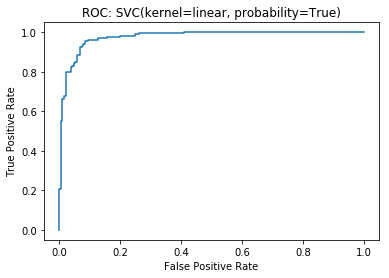

In [123]:
plot_roc_calc_auc_audio(SVC(kernel='linear', probability=True))

# SVC

In [126]:
param_grid = {'kernel': ['poly', 'rbf', 'sigmoid']}
svc_best = grid_cv(estimator=SVC(), param_grid=param_grid)
svc_best

{'kernel': 'rbf'}

In [127]:
score_estimator(SVC(**svc_best))

{'accuracy_score': 0.884496115427303,
 'f1_score': 0.8985263638275345,
 'precision_score': 0.8713291352597322,
 'recall_score': 0.9287553648068669}

'AUC: 0.9953191489361702'

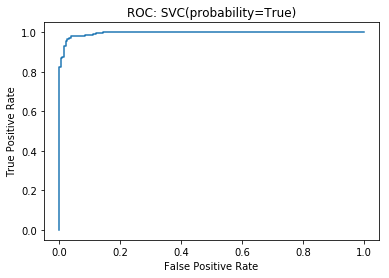

In [128]:
plot_roc_calc_auc_audio(SVC(probability=True, **svc_best))

# Decision Tree

In [97]:
param_grid = {'criterion': ['gini', 'entropy']}
dectree_best = grid_cv(DecisionTreeClassifier(), param_grid=param_grid)
dectree_best

{'criterion': 'entropy'}

In [98]:
score_estimator(DecisionTreeClassifier(**dectree_best))

{'accuracy_score': 0.8217824639289677,
 'f1_score': 0.8415599233925313,
 'precision_score': 0.8401671555581502,
 'recall_score': 0.8532188841201718}

'AUC: 0.9031914893617021'

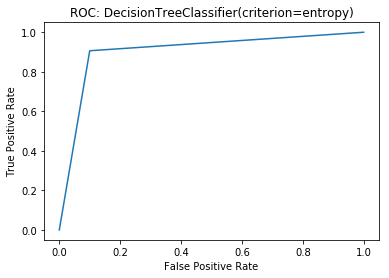

In [117]:
plot_roc_calc_auc_audio(DecisionTreeClassifier(**dectree_best))

# Random Forest

In [100]:
param_grid = {'criterion': ['gini', 'entropy']}
randforest_best = grid_cv(RandomForestClassifier(), param_grid=param_grid)
randforest_best

{'criterion': 'entropy'}

In [101]:
score_estimator(RandomForestClassifier(**randforest_best))

{'accuracy_score': 0.87365371809101,
 'f1_score': 0.884735323671071,
 'precision_score': 0.8877706829976141,
 'recall_score': 0.8978540772532189}

'AUC: 0.9777379619260917'

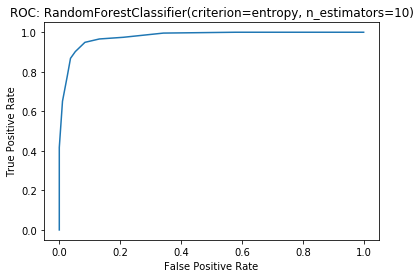

In [118]:
plot_roc_calc_auc_audio(RandomForestClassifier(**randforest_best))